# Automated Model Discovery With The Bayesian Machine Scientist

In this tutorial, we will walk through how to use the Bayesian Machine Scientist to recover models. We will compare its performance to baseline models taken from Sci-kit Learn.

## Continuous Model Recovery

1. Install relevant subpackages from AutoRA

In [ ]:
!pip install -q "autora[theorist-bms]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.5 MB/s eta 0:00:00


2. Import relevant modules from AutoRA

In [ ]:
from autora.theorist.bms import BMSRegressor
from autora.experiment_runner.synthetic.psychophysics.weber_fechner_law import weber_fechner_law
import numpy as np
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

3. Import your data
*(Here we create noisy synthetic data as a demonstration)*

In [ ]:
# experimental parameter to recover
constant = 3.0

# synthetic experiment from autora inventory
synthetic_data = weber_fechner_law(constant=constant, added_noise=0.01)

# experimental data
conditions = synthetic_data.domain()
observations = synthetic_data.experiment_runner(conditions)

# split into train and test datasets
conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

### Comparing Models

We will repeat these steps for each model
4. Initialize Model
5. Fit Model to the Data
6. Plot the Results

#### Some Functions you can use to plot

In [ ]:
def present_results(model, x_test, y_test, arg='default', model_name=None, variable_names=None, select_indices=None, figsize=None, *args):
  compare_results(models=[model], x_test=x_test, y_test=y_test, arg=arg, model_names=[model_name], variable_names=variable_names, select_indices=select_indices, figsize=figsize, *args)

In [ ]:
def compare_results(models, x_test, y_test, arg='default', model_names=None, variable_names=None, observation_name=None, select_indices=None, figsize=None, *args):
  if model_names is None or model_names == [None]:
    names = ['Model '+str(i+1) for i in range(len(models))]
  else:
    names = model_names
  if len(x_test.shape) == 1:
    x_test = x_test.reshape(1, -1)
  num_var = x_test.shape[1]
  if variable_names is None:
    var_names = ['Variable '+str(i+1) for i in range(num_var)]
  else:
    var_names = variable_names
  if observation_name is None:
    obs_label = 'Observations'
  else:
    obs_label = observation_name
  match arg:
    case 'default':
      for i, model in enumerate(models):
        print(model)
        synthetic_data.plotter(model)
    case '2d':
      if figsize is None:
        size = (8,3)
      else:
        assert len(figsize) == 2 and isinstance(figsize, tuple), 'incorrect format for figure shape\nshould be tuple of form (i,j)'
        size = figsize
      for i, model in enumerate(models):
        fig = plt.figure(figsize=size)
        axes = []
        y_predict = model.predict(x_test)
        for j in range(num_var):
          axes.append(fig.add_subplot(1, num_var, j+1))
          axes[j].set_xlabel(var_names[j])
          axes[j].set_ylabel(obs_label)
          axes[j].set_title(names[i]+' fit on '+var_names[j])
          axes[j].scatter(x_test[:,j], y_test, label='Ground Truth', alpha=0.5)
          axes[j].scatter(x_test[:,j], y_predict, label='Predicted', alpha=0.5)
          axes[j].legend()
          for arg in args:
            assert isinstance(arg, str), 'arguments must be in the form of a string'
            try:
              exec('axes[j].'+arg)
            except:
              raise RuntimeError(f'argument "{arg}" could not be executed')

      fig.tight_layout()
      plt.show()
    case '3d':
      if figsize is None:
        size = (15,5)
      else:
        assert len(figsize) == 2 and isinstance(figsize, tuple), 'incorrect format for figure shape\nshould be tuple of form (i,j)'
        size = figsize
      axes = []
      fig = plt.figure(figsize=size)
      if select_indices is None:
        idx = (0,1)
      else:
        len(select_indices) == 2 and isinstance(select_indices, tuple), 'incorrect format for select_indices\nshould be tuple of form (i,j)'
        idx = select_indices
      for i, model in enumerate(models):
        y_predict = model.predict(x_test)
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axes.append(ax)
        axes[i].set_xlabel(var_names[idx[0]])
        axes[i].set_ylabel(var_names[idx[1]])
        axes[i].set_zlabel(obs_label)
        axes[i].scatter(x_test[:, idx[0]], x_test[:, idx[1]], y_test, s=1, label='Ground Truth')
        axes[i].scatter(x_test[:, idx[0]], x_test[:, idx[1]], y_predict, s=1, label='Predicted')
        axes[i].set_title(names[i])
        axes[i].legend()
        axes[i].set_facecolor('white')
        for arg in args:
            assert isinstance(arg, str), 'arguments must be in the form of a string'
            try:
              exec('axes[j].'+arg)
            except:
              raise RuntimeError(f'argument "{arg}" could not be executed')
      fig.tight_layout()
      plt.show()
    case 'choice':
      for model in models:
        y_pred = np.where(model.predict(x_test) > 0.5, 1, 0)
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        plt.show()

### 1. Polynomial Regressor

*make model* if needed

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

4. Initialize the model

In [ ]:
np.random.seed(0)
poly_model = PolynomialRegressor(degree=3)

5. Fit Model to the Data

In [ ]:
poly_model.fit(conditions_train, observations_train)

6. Plot the Results

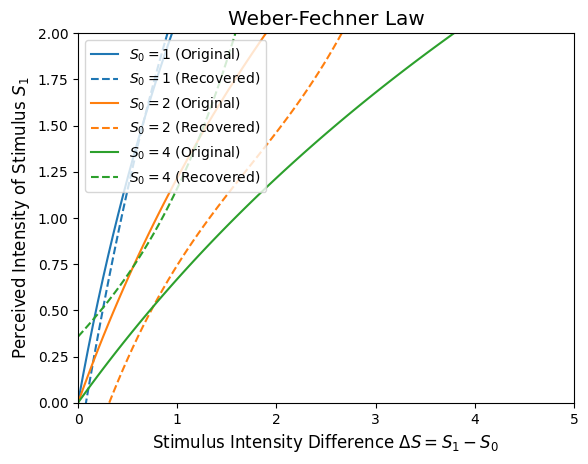

In [ ]:
present_results(model=poly_model, x_test=conditions_test, y_test=observations_test)

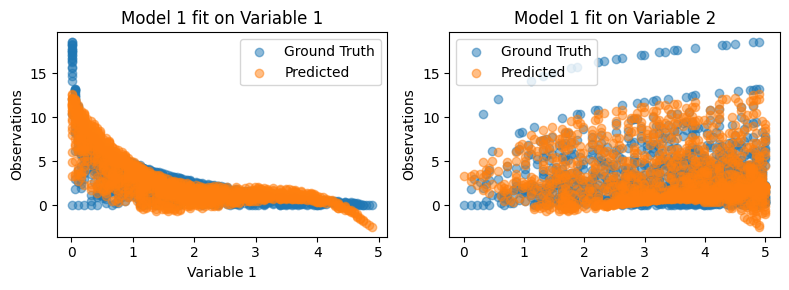

In [ ]:
present_results(model=poly_model, x_test=conditions_test, y_test=observations_test, arg='2d')

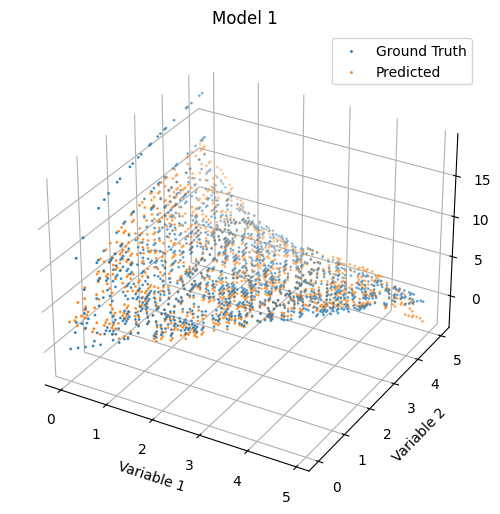

In [ ]:
present_results(model=poly_model, x_test=conditions_test, y_test=observations_test, arg='3d')

In [ ]:
print(poly_model.model_)

AttributeError: ignored

#### Summary - Polynomial Linear Regressor

Expressivity: Low

Interpretability: High

### 2. Neural Network


4. Initialize Model

In [ ]:
from sklearn.neural_network import MLPRegressor
import torch
nn_model = MLPRegressor(random_state=1, max_iter=500)

5. Fit Model to the Data

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
nn_model.fit(conditions_train, observations_train)

MLPRegressor(max_iter=500, random_state=1)

6. Plot the Results

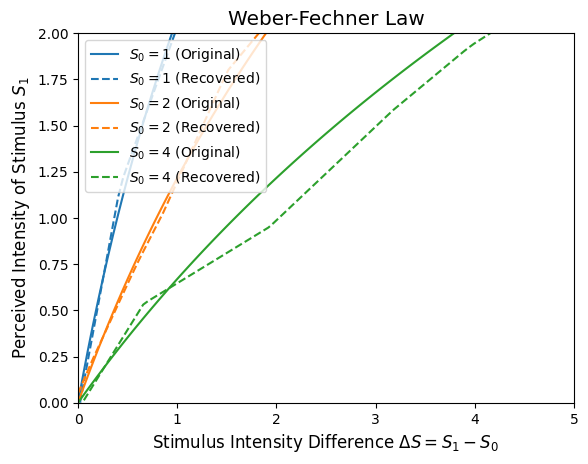

In [ ]:
synthetic_data.plotter(nn_model)

#### Summary - Neural Network Regressor

Expressivity: High

Interpretability: Low

### 3. Bayesian Machine Scientist

4. Initialize Model

In [ ]:
bms_model = BMSRegressor(epochs=1500)

5. Fit Model to Data

In [ ]:
bms_model.fit(conditions_train, observations_train, seed=0)

100%|██████████| 1500/1500 [08:57<00:00,  2.79it/s]


log(((X0 / X1) ** -3.0))

6. Plot the Results

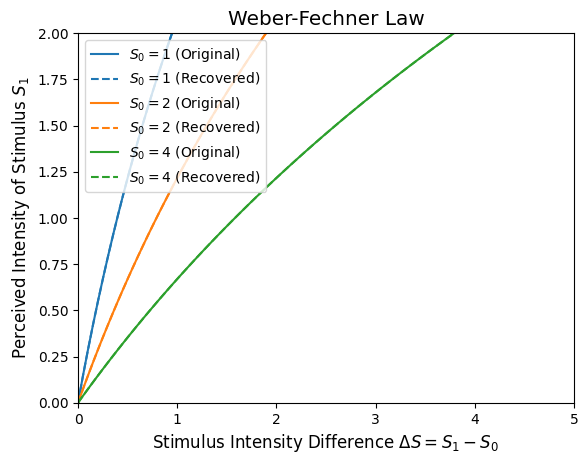

In [ ]:
synthetic_data.plotter(bms_model)

In [ ]:
print(bms_model)

log(((X0 / X1) ** -3.0))


#### Summary - BMS Regressor

Expressiveness: High

Interpretability: High


### Summary - Model Comparison

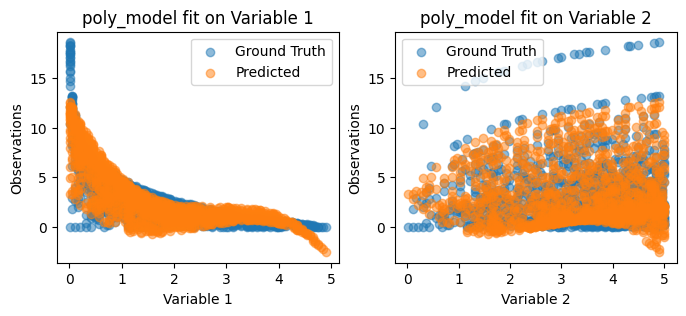

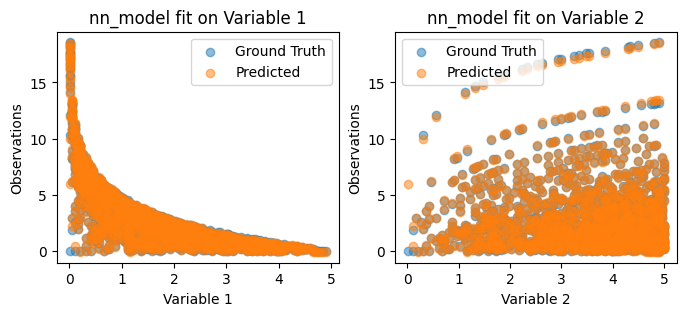

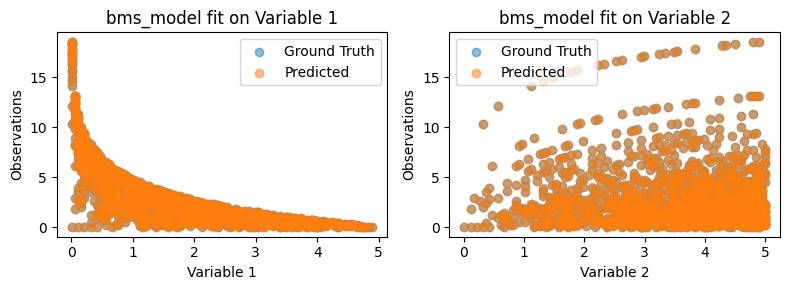

In [ ]:
models = [poly_model, nn_model, bms_model]
names =['poly_model', 'nn_model', 'bms_model']
compare_results(models=models, x_test=conditions_test, y_test=observations_test, model_names=names, arg='2d')

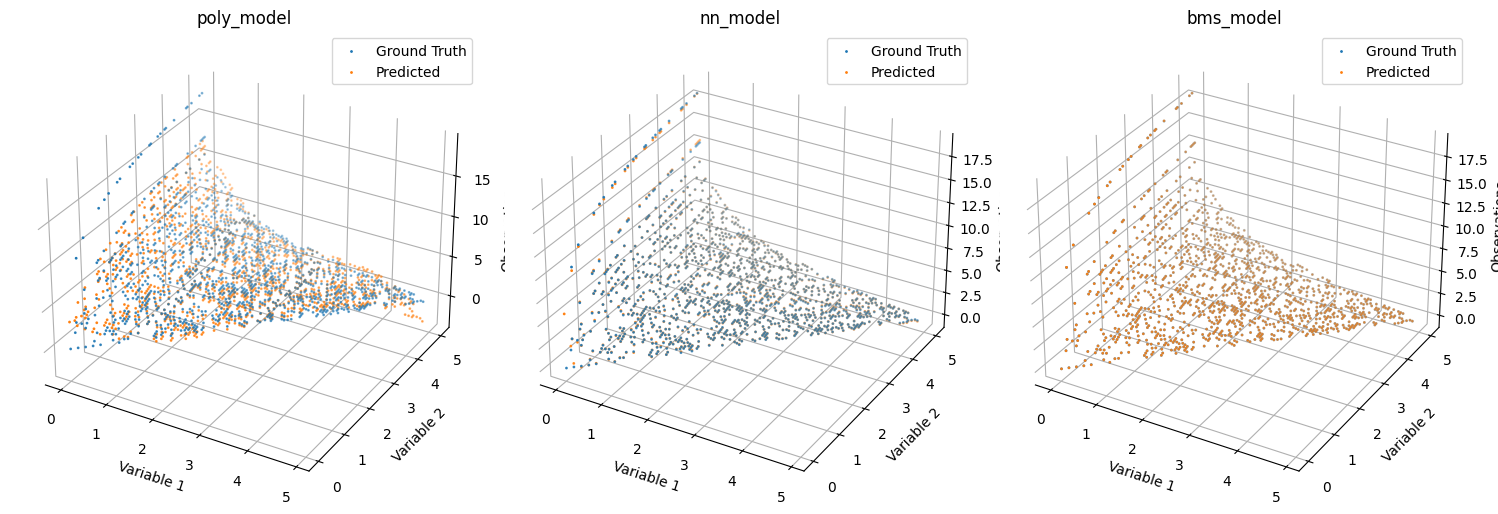

In [ ]:
compare_results(models=models, x_test=conditions_test, y_test=observations_test, model_names=names, arg='3d')

## Choice Model Recovery

2. Import relevant modules from AutoRA

In [ ]:
from autora.experiment_runner.synthetic.psychology.luce_choice_ratio import luce_choice_ratio

3. Import your data
*(Here we create noisy synthetic data as a demonstration)*

In [ ]:
# experimental parameter to recover
focus = 0.8

# synthetic experiment from autora inventory
synthetic_data = luce_choice_ratio(focus=focus, added_noise=0.01)

# experimental data
conditions = synthetic_data.domain()
observations = synthetic_data.experiment_runner(conditions)

# set probabilities to choice values
observations = np.where(observations < 0.5, 0, 1)

# split into train and test datasets
conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

4. Initialize Model
5. Fit Model to the Data
6. Plot the Results

### Comparing Models

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Logistic Regressor

4. Initialize Model

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()

5. Fit Model to the Data

In [ ]:
log_model.fit(conditions_train, observations_train)
# log_model.predict(conditions_test)

LogisticRegression()

6. Plot the Results

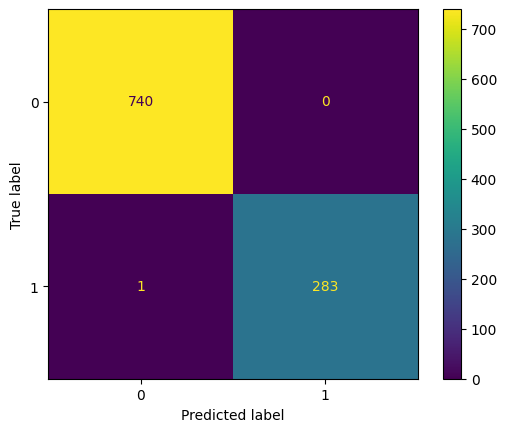

In [ ]:
present_results(model=log_model, x_test=conditions_test, y_test=observations_test, arg='choice')

#### Summary - Logisitic Regressor

Expressiveness: Low

Interpretability: Medium

### Neural Network Classifier

4. Initialize Model

In [ ]:
from sklearn.neural_network import MLPClassifier

nn_class_model = MLPClassifier(max_iter=3000, activation='logistic')

5. Fit Model to the Data

In [ ]:
nn_class_model.fit(conditions_train, observations_train)

MLPClassifier(activation='logistic', max_iter=3000)

6. Plot the Results

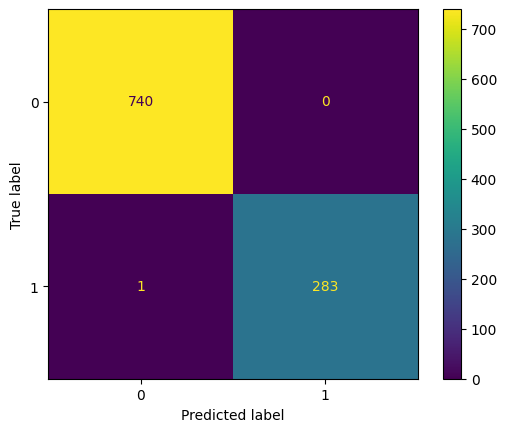

In [ ]:
present_results(model=nn_class_model, x_test=conditions_test, y_test=observations_test, arg='choice')

#### Summary - Neural Network Regressor

Expressiveness: High

Interpretability: Low

### Bayesian Machine Scientist

4. Initialize Model

In [ ]:
bms_model = BMSRegressor(epochs=1500)

5. Fit Model to the Data

In [ ]:
bms_model.fit(conditions_train, observations_train, seed=0)

100%|██████████| 1500/1500 [14:06<00:00,  1.77it/s]


tan(sqrt(-(log(cos((tanh(X0) ** (((X3 + 5.3) ** X1) * (X2 + (X2 * ((X2 / 5.3) + X3))))))))))

6. Plot the Results

tan(sqrt(-(log(cos((tanh(X0) ** (((X3 + 5.3) ** X1) * (X2 + (X2 * ((X2 / 5.3) + X3))))))))))


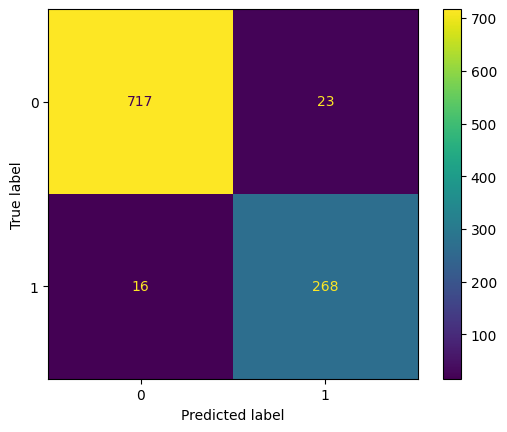

In [ ]:
print(bms_model)
present_results(model=bms_model, x_test=conditions_test, y_test=observations_test, arg='choice')

#### Summary - BMS Regressor

Expressiveness: High

Interpretability: High


### Summary - Model Comparison

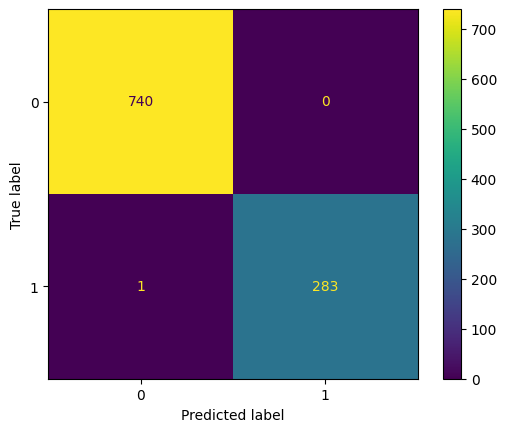

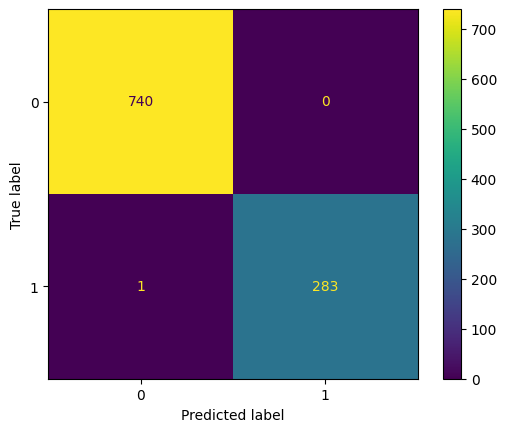

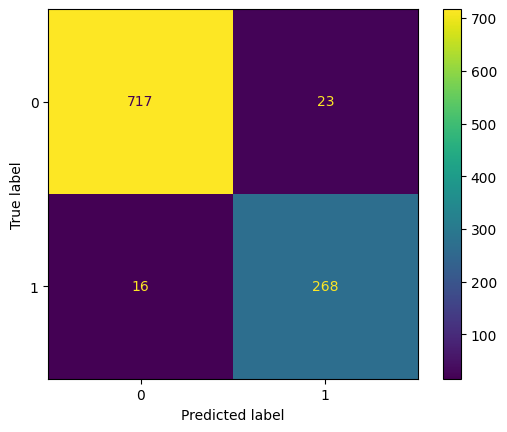

tan(sqrt(-(log(cos((tanh(X0) ** (((X3 + 5.3) ** X1) * (X2 + (X2 * ((X2 / 5.3) + X3))))))))))


In [ ]:
present_results(model=log_model, x_test=conditions_test, y_test=observations_test, arg='choice')
present_results(model=nn_class_model, x_test=conditions_test, y_test=observations_test, arg='choice')
present_results(model=bms_model, x_test=conditions_test, y_test=observations_test, arg='choice')
print(bms_model)

## Exercises

### FYI: AutoRA Toolkit Pre-release for integrating symbolic regression into any other modeling method of your choice

### Exercise 1: Try it yourself!

1. Install packages

In [ ]:
# Install package that you will need here


2. Import packages

In [ ]:
# Import packages you will need here
import pandas

3. Load Data

In [ ]:
## Uncomment the next lines and input the file location or replace with a line of your own
# FILE_LOCATION = ''
# df = pd.read_csv(FILE_LOCATION)

## Extract your conditions and observations from your loaded data
# conditions =
# observations =

## Run this line and make sure you train with the train datasets and test with the test datasets
## This ensures that your model hasn't overfit
# conditions_train, conditions_test, observations_train, observations_test = train_test_split(conditions, observations)

4. Initialize Model

In [ ]:
# We will use BMS for this exercise. Feel free to initialize another model to compare it to
# Minimum recommended number of epochs is 1500
bms_model = BMSRegressor(epochs=1500)

5. Fit model to the Data

In [ ]:
## Uncomment this next line after you have completed step 3
# bms_model.fit(conditions_train, observations_train)

6. Plot the results

In [ ]:
## Uncomment this next line after you have completed step 5
# plot_type = "default", "2d", "3d", or "choice"
# present_results(bms_model, conditions_test, observations_test, arg=plot_type)

## You can uncomment these lines if you would like to compare BMS to a model of your choice
# your_models_name =
# your_model =
#
# models = [bms_model, your_model]
# model_names = ["bms_model", your_models_name]
# compare results(models=models, x_test=conditions_test, y_test=observations_test, model_names=model_names, arg=plot_type)

### Exercise 2: Using the AutoRA closed loop

See https://autoresearch.github.io/autora/tutorials/Introduction/ for a tutorial on closed-loop experimentation.